International Monetary Fund API with Python
=====

## Brazil, Chile, and Colombia CPI inflation example

*January 6, 2026*<br>
*@bd_econ*

-----

Updated example using sdmx1 (pip install sdmx1)

In [1]:
import pandas as pd
import sdmx

In [2]:
# parameters
countries = ['BRA', 'CHL', 'COL']
dataset = 'CPI'
series = '_T.IX.M'
key = f"{'+'.join(countries)}.{dataset}.{series}"

In [3]:
# retrieve data
IMF_DATA = sdmx.Client('IMF_DATA')
data_msg = IMF_DATA.data('CPI', key=key, 
                         params={'startPeriod': 2018})

# convert to pandas
df = sdmx.to_pandas(data_msg).reset_index()
df = df.set_index(['TIME_PERIOD', 'COUNTRY'])['value'].unstack()

xml.Reader got no structure=… argument for StructureSpecificData


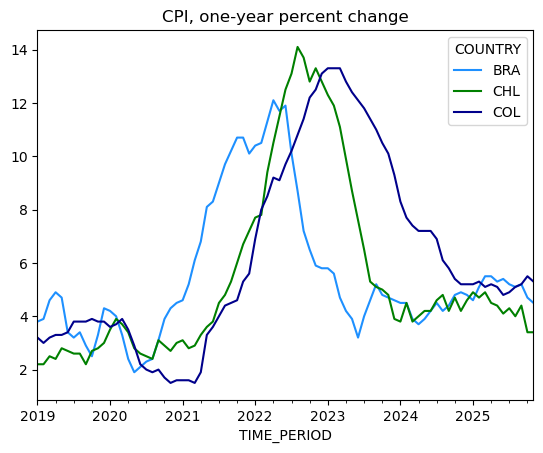

In [4]:
# Convert index to datetime
df.index = pd.to_datetime(df.index, format='%Y-M%m')

# Calculate inflation rate and drop empty rows
res = (df.pct_change(12) * 100).round(1).dropna()

# Plot results
res.plot(title='CPI, one-year percent change',
         color=['dodgerblue', 'green', 'darkblue']);

### Exmple 2: How to Find Parameters

In [5]:
# dataflow method
f = IMF_DATA.dataflow()
# Search for "trade"
{i: v for i, v in f.dataflow.items() if 'Trade' in v.name['en']}

{'ITG_WCA': <DataflowDefinition IMF.STA:ITG_WCA(2.0.4): International Trade in Goods, World and Country Aggregates>,
 'CTOT': <DataflowDefinition IMF.RES:CTOT(5.0.1): Commodity Terms of Trade (CTOT)>,
 'ITG': <DataflowDefinition IMF.STA:ITG(4.0.0): International Trade in Goods (ITG)>,
 'TEG': <DataflowDefinition IMF.STA:TEG(3.0.2): Trade in Low Carbon Technology Goods (TEG)>,
 'ITS': <DataflowDefinition IMF.RES:ITS(3.0.1): International Trade in Services (ITS)>,
 'IMTS': <DataflowDefinition IMF.STA:IMTS(1.0.0): International Trade in Goods (by partner country) (IMTS)>}

In [6]:
# Get metadata for 'IMTS'
f = IMF_DATA.dataflow('IMTS')
dsd = f.structure['DSD_IMTS']
dsd.dimensions.components

[<Dimension COUNTRY>,
 <Dimension INDICATOR>,
 <Dimension COUNTERPART_COUNTRY>,
 <Dimension FREQUENCY>,
 <TimeDimension TIME_PERIOD>]

In [7]:
# Indicator codes
codes = f.codelist.CL_IMTS_INDICATOR
sdmx.to_pandas(codes)

CL_IMTS_INDICATOR
XG_FOB_USD     Exports of goods, Free on board (FOB), US dollar
MG_FOB_USD     Imports of goods, Free on board (FOB), US dollar
MG_CIF_USD    Imports of goods, Cost insurance freight (CIF)...
TBG_USD                          Trade balance goods, US dollar
Name: International Trade in Goods (by partner country) (IMTS) Indicator, dtype: object

In [8]:
# Country codes
codes = f.codelist.CL_IMTS_COUNTRY
res = sdmx.to_pandas(codes)
res.loc[res.str.contains('World')]

CL_IMTS_COUNTRY
G001    World
Name: International Trade in Goods (by partner country) (IMTS) Country, dtype: object

In [9]:
# retrieve data
IMF_DATA = sdmx.Client('IMF_DATA')
data_msg = IMF_DATA.data('IMTS', key='GBR.MG_CIF_USD.G001+G998.M')

# convert to pandas
df = sdmx.to_pandas(data_msg).reset_index()
df = df.set_index(['TIME_PERIOD', 'COUNTERPART_COUNTRY'])['value'].unstack()
# Convert index to datetime
df.index = pd.to_datetime(df.index, format='%Y-M%m')

xml.Reader got no structure=… argument for StructureSpecificData


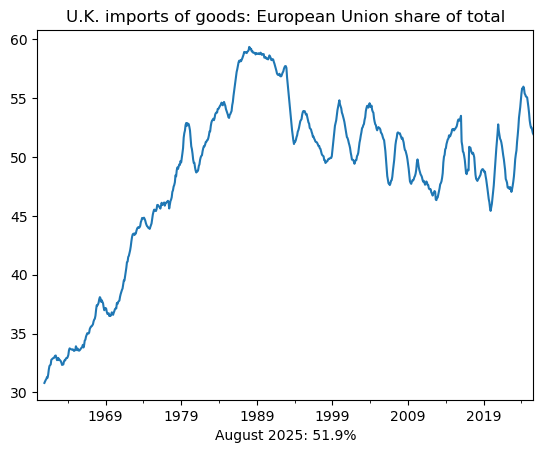

In [10]:
# Calculate EU share of UK imports of goods
eu_share = ((df['G998'] / df['G001']) * 100).rolling(12).mean()
# Create a line plot and print most recent value as x label
title = "U.K. imports of goods: European Union share of total"
recent = f"{eu_share.index[-1].strftime('%B %Y')}: {eu_share.iloc[-1]:.1f}%"
ax = eu_share.plot(title=title)
ax = ax.set_xlabel(recent)